In [1]:
%matplotlib notebook

In [2]:
import eol_finesse_library as eollib
import numpy as np
import matplotlib
#import ipympl
#matplotlib.use('inline')
#matplotlib.use("agg")
import matplotlib.pyplot as plt
matplotlib.interactive(True)
from pykat import finesse, commands

                                              ..-
    PyKat 1.1.269         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## 1. Setup the laser source parameters and kat code

In [3]:
l1_params = eollib.LaserParams(power=1, freq=0, phase=0)
l1_tems = {'0 0': {'pwr': 1.0, 'phase': 0},
           '0 2': {'pwr': 0.0, 'phase': 0},
           '2 0': {'pwr': 0.0, 'phase': 0}}
l2_params = eollib.LaserParams(power=0.2, freq="$f1", phase=0)
l2_tems = {'0 0': {'pwr': 0.0, 'phase': 180},
           '0 2': {'pwr': 0.1, 'phase': 180},
           '2 0': {'pwr': 0.1, 'phase': 180}}
l3_params = eollib.LaserParams(power=0.2, freq="$f2", phase=0)
l3_tems = {'0 0': {'pwr': 0.0, 'phase': 90},
           '0 2': {'pwr': 0.1, 'phase': 90},
           '2 0': {'pwr': 0.1, 'phase': 90}}

# let's generate the part of kat code that defines the laser source:
source = eollib.shifted_lasers(l1_params, l2_params, l3_params, l1_tems, l2_tems, l3_tems, print_code=True)


    #--------------> Laser 1 <--------------------
    l i1 1 0 0 nin1    # main laser
    s sBS1 0.01 nin1 nBS1_in
    #----- l1 tem modes ---------
    tem i1 0 2 0.0 0
    tem i1 0 0 1.0 0
    tem i1 2 0 0.0 0
    
    #--------------> Laser 2 <--------------------
    l i2 0.2 $f1 0 nin2    # sideband laser 1
    s sBS2 0.01 nin2 nBS2_in
    #----- l2 tem modes --------
    tem i2 0 2 0.1 180
    tem i2 0 0 0.0 180
    tem i2 2 0 0.1 180
    
    #--------------> Laser 3 <--------------------
    l i3 0.2 $f2 0 nin3    # sideband laser 2
    s sBS3 0.01 nin3 nBS2_4
    #----- l3 tem modes --------
    tem i3 0 2 0.1 90
    tem i3 0 0 0.0 90
    tem i3 2 0 0.1 90

    #----------------------------> Beam Splitter 1 <--------------------------
    bs BS1 0.5 0.5 0 0 nBS1_in nBS1_2 n_source_out nBS1_4 
    #----------------------------> Beam Splitter 2 <--------------------------
    bs BS2 0.5 0.5 0 0 nBS2_in nBS2_2 nBS2_3 nBS2_4 
    #----------------------------> BS length connecti

## 2. Setup the cavity

In [4]:
base = 0.15   # short side 15 cm
height = 1.5
side = np.sqrt((base / 2)**2 + height**2)

lengths = [base, side, side]
# angles and mirror parameters are listed in the same order as their opposing side 
curv_radii = [6.0, 'inf', 'inf']
reflectivities = [1, 0.98, 0.98] # end mirror should be 0.995 in the real setup. No losses are considered for now. 
#let's build the cavity kat code
tri_cav = eollib.triangular_cavity_builder(lengths, curv_radii, reflectivities, print_code=True)

Cavity angles:
5.725°, 87.138°, 87.138°

    #-------------------------> Triangular Cavity <---------------------------
    
    # -------- cavity mirrors/beamsplitters ----------
    bs bs_in  0.9800 0.0200  0  43.569  c_ref     c_in    b_in_3   b_in_4   # cavity "input" left base beam splitter
    bs bs_out 0.9800 0.0200  0  43.569  c_tra  b_out_2    b_out_3  b_out_4  # cavity "output" right base beam splitter
    bs bs_end 1.0000 0.0000  0  2.862  b_end_1  b_end_2  b_end_3  b_end_4     # cavity end mirror
    
    
    # ------------ in-cavity spaces ---------------
    s  s_c_bot 0.1500  b_out_3 b_in_4                          # cavity short "bottom / base" side
    s  s_c_1   1.5019  b_in_3  b_end_2                         # cavity long left side
    s  s_c_2   1.5019  b_end_1 b_out_4                         # cavity long right side
    
    
    # ------------ curvature radii -------------
    attr bs_end  Rc 6.0
    attr bs_in   Rc inf  
    attr bs_out  Rc inf  # come funzia la

## 3. Setup the connecting spaces an the detectors and the modulation/demodulation frequencies

In [5]:
out_cav_spaces = """
s s0 0.1 n_source_out c_in
s s_tra 0.1 c_tra  n_tra
"""

In [6]:
detectors = """
# Amplitude detectors in transmission
# --- order 0
ad adt00 0 0 0 n_tra
ad adtSB+00 0 0 $f1 n_tra
ad adtSB-00 0 0 $f2 n_tra
# --- order 1
ad adt10 1 0 0 n_tra
ad adt01 0 1 0 n_tra
ad adtSB+10 1 0 $f1 n_tra
ad adtSB+01 0 1 $f1 n_tra
ad adtSB-10 1 0 $f2 n_tra
ad adtSB-01 0 1 $f2 n_tra
# --- order 2
ad adt20 2 0 0 n_tra
ad adt02 0 2 0 n_tra
ad adt11 1 1 0 n_tra
ad adtSB+20 2 0 $f1 n_tra
ad adtSB+02 0 2 $f1 n_tra
ad adtSB+11 1 1 $f1 n_tra
ad adtSB-20 2 0 $f2 n_tra
ad adtSB-02 0 2 $f2 n_tra
ad adtSB-11 1 1 $f2 n_tra
# --- order 3
#ad adt30 3 0 0 n_tra
#ad adt03 0 3 0 n_tra

# Amplitude detectors in reflection
# --- order 0
ad adr00 0 0 0 c_ref
ad adrSB+00 0 0 $f1 c_ref
ad adrSB-00 0 0 $f2 c_ref
# --- order 1
ad adr10 1 0 0 c_ref
ad adr01 0 1 0 c_ref
ad adrSB+10 1 0 $f1 c_ref
ad adrSB+01 0 1 $f1 c_ref
ad adrSB-10 1 0 $f2 c_ref
ad adrSB-01 0 1 $f2 c_ref
# --- order 2
ad adr20 2 0 0 c_ref
ad adr02 0 2 0 c_ref
ad adr11 1 1 0 c_ref
ad adrSB+20 2 0 $f1 c_ref
ad adrSB+02 0 2 $f1 c_ref
ad adrSB+11 1 1 $f1 c_ref
ad adrSB-20 2 0 $f2 c_ref
ad adrSB-02 0 2 $f2 c_ref
ad adrSB-11 1 1 $f2 c_ref
# --- order 3
#ad adr30 3 0 0 c_ref
#ad adr03 0 3 0 c_ref



# Photodetectors
pd PDt          n_tra
pd PDr          c_ref
pd PDout2       b_out_2      # output mirror "reverse transmission"
pd PDinput_refl c_in         # backreflection on the input port
pd PDend_tra1   b_end_3      # end mirror transmission
pd PDend_tra2   b_end_4      # end mirror "reverse" transmission

pd1 inphase $f1 270 c_ref        # photo diode + mixer demodulated at f1 . The real demodulation phase will be set later. 
                             
pd1 quadrature $f1 360 c_ref      # photo diode + mixer demodulated at f1. The real demodulation phase will be set later.
  
"""

In [7]:
constants = """
# Sideband and demodulation frequencies
const f1 32.58M
const f2 -32.58M
maxtem 4
"""

### 3.1 setup an initial sweep in order to tune the demodulation phase of the PDH photodiodes

### 3.1.0 in order to tune the demod phase we need to temporarily add 02 and 20 components to the carrier laser too.

In [8]:
pdh_l1_tems = {'0 0': {'pwr': 0.7, 'phase': 0},
           '0 2': {'pwr': 0.15, 'phase': 0},
           '2 0': {'pwr': 0.15, 'phase': 0}}
pdh_source = eollib.shifted_lasers(l1_params, l2_params, l3_params, pdh_l1_tems, l2_tems, l3_tems, print_code=False)

In [9]:
## to perform the phase tuning let's generate a slow (1Hz) oscillation of the end mirror and let's measure the PDH response to it
# at different photodiode demodulation phases.
phase_tuning_sweep = """fsig end_mod bs_end 1 0
pd2 sweeper $f1 0 1 c_ref
xaxis sweeper phi1 lin -90 90 2000
yaxis abs:deg
"""

# let's finally build  and parse the kat code for the pdh phase tuning
phase_tuning_tri_kat = finesse.kat()
#tri_kat.verbose = True
code = ""
for c in [pdh_source, out_cav_spaces, tri_cav, detectors, constants, phase_tuning_sweep]:
    code += c
#print(code)
phase_tuning_tri_kat.parse(code)

Parsing `tem i1 0 2 0.15 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 0 0 0.7 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 2 0 0.15 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 2 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 0 0.0 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 2 0 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 2 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 0 0.0 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 2 0 0.1 90` into pykat object not implemented yet, added as extra line.


Let's run the code and find the demodulation phase that gives the maximum response to the slow modulation

In [10]:
phase_tuning_out = phase_tuning_tri_kat.run()

a = np.argmax(np.abs(phase_tuning_out['sweeper']))
phi = phase_tuning_out.x[a]
print("inphase maximum found at phi={phi}°".format(phi=phi))

--------------------------------------------------------------
Running kat - Started at 2018-07-30 16:06:38.790605


100% | ETA:  0:00:00 | Calculating                                             


Finished in 5.54435 seconds
inphase maximum found at phi=-1.53°


<IPython.core.display.Javascript object>


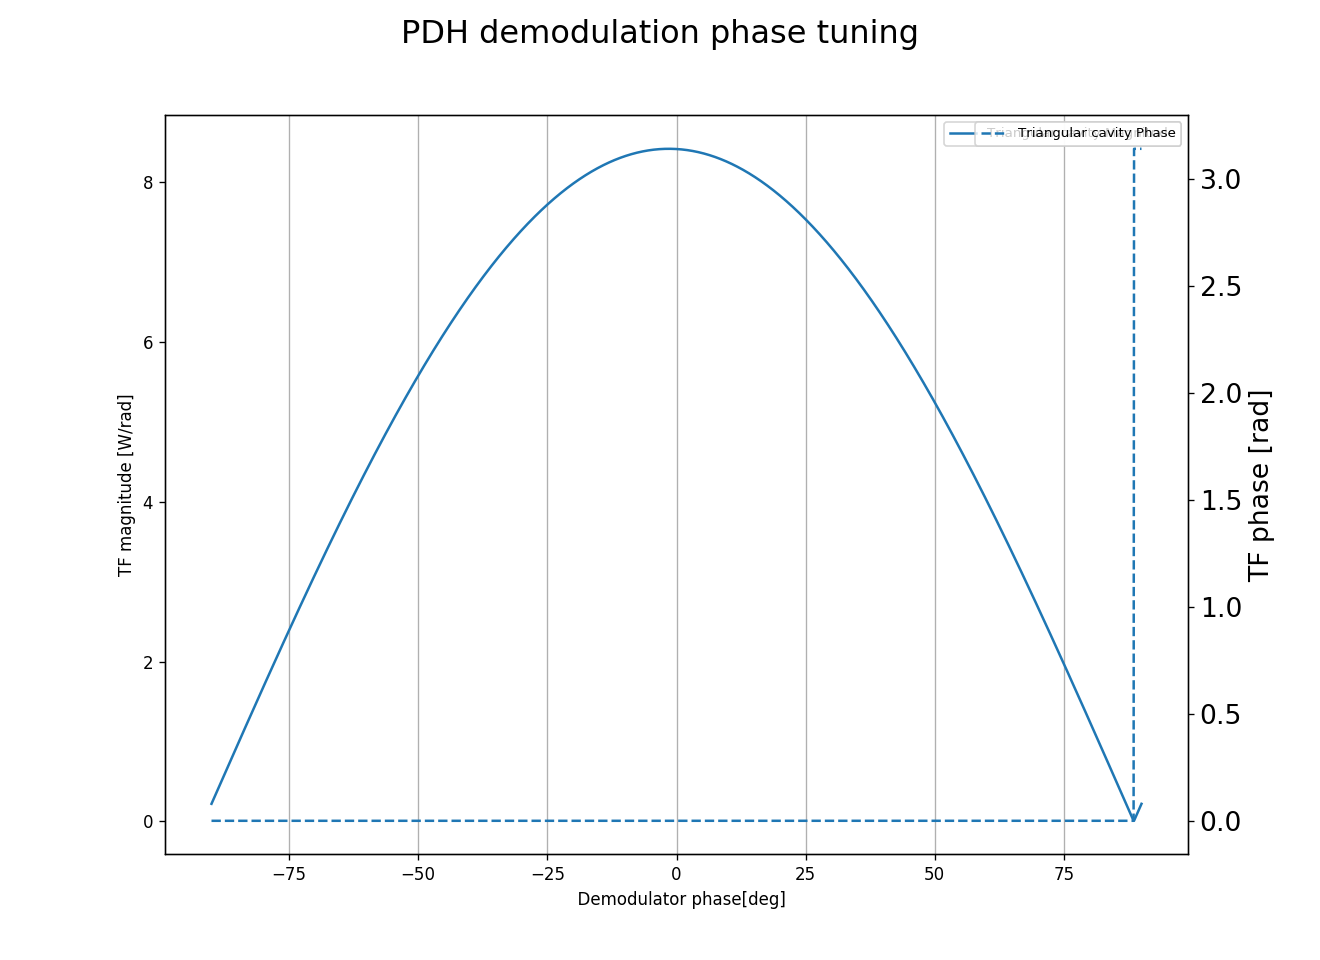

(<matplotlib.figure.Figure at 0x7fb7893c0e48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb7893c4780>)

In [11]:
phase_tuning_out_dict = {"Triangular cavity" : phase_tuning_out}
eollib.plot_phi_tuning(phase_tuning_out_dict)

## 4. To perform another check before the mismatch studies, let's setup a cavity scan xaxis run and run it

In [12]:
cavity_sweep = """
xaxis bs_end phi lin -90 90 1200       # x-axis : mirror displacement
yaxis abs:deg                      # y-axis : Intensity and Phase
"""

### Let's put together the pieces of kat code and then parse them.

In [13]:
tri_kat = finesse.kat()
#tri_kat.verbose = True
code = ""
for c in [source, out_cav_spaces, tri_cav, detectors, constants, cavity_sweep]:
    code += c
#print(code)
tri_kat.parse(code)
tri_kat.trace=8
tri_kat.inphase.phase1 = phi
tri_kat.quadrature.phase1 = phi + 90

Parsing `tem i1 0 2 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 0 0 1.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 2 0 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 2 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 0 0.0 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 2 0 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 2 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 0 0.0 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 2 0 0.1 90` into pykat object not implemented yet, added as extra line.


In [14]:
cav_sweep_out = tri_kat.run()
out_dict = {"Tri cav sweep" : cav_sweep_out}   # this dictionary contains the results and is used by my plotting functions.
#print(cav_sweep_out.stdout)

--------------------------------------------------------------
Running kat - Started at 2018-07-30 16:06:44.496044


100% | ETA:  0:00:00 | Calculating                                             


Finished in 1.07591 seconds


## 5. Print and Plot the Cavity Scan results (using some plotting functions I moved in the eol library)

In [15]:
def print_cavity_parameters(kat_out):
    print('finesse --->', kat_out['cav1_x_finesse'][0])
    print('fsr       --->', kat_out['cav1_x_fsr'][0])
    print('Waist radius  --->', kat_out['cav1_x_w0'][0])
    print('z       --->', kat_out['cav1_x_z'][0])

In [16]:
print_cavity_parameters(cav_sweep_out)

finesse ---> (155.498258186+0j)
fsr       ---> (95057536.3054+0j)
Waist radius  ---> (0.000945354605395+0j)
z       ---> (0.075+0j)


<IPython.core.display.Javascript object>


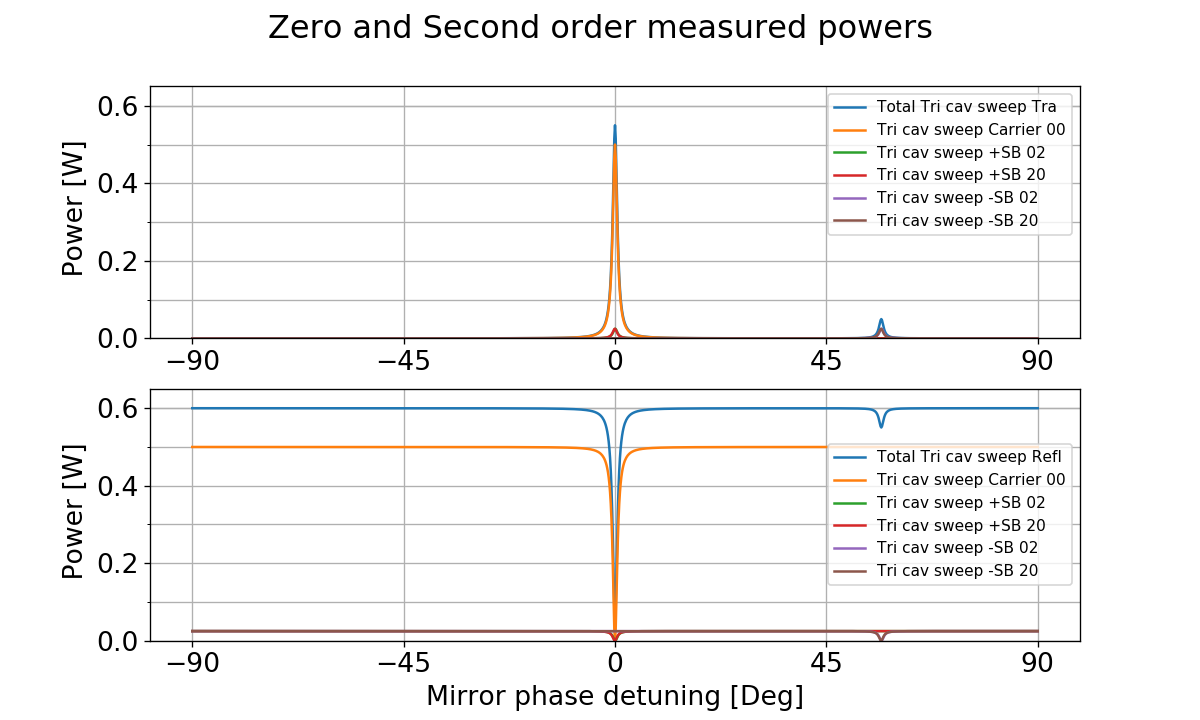

/home/mikelovskij/.local/Anaconda/envs/py34/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [17]:
#eollib.plot_powers(out_dict, save_plot=True)
#eollib.plot_phases(out_dict, save_plot=True)
#eollib.plot_total_powers(out_dict, save_plot=True)
#eollib.plot_pdh(out_dict, save_plot=True)
fig,ax = eollib.plot_trans_refl(out_dict, save_plot=False)

# 6. LET's try to find a mode matching error signal! 

(shall we fix the gauss parameters at the lasers? Yes.)

In [18]:
#fix the gauss params at the lasers
#gauss_params_lasers = """
#gauss gauss1 i1 nin1 945.35u -0.185 946.15u -0.185
#gauss gauss2 i2 nin2 945.35u -0.285 946.15u -0.285
#gauss gauss3 i3 nin3 945.35u -0.285 946.15u -0.285
#startnode nin1
#retrace force
#"""

# fix the gauss params at the output of BS1 instead where they are already recombined.
gauss_params = """
gauss gauss1 BS1 n_source_out 945.35u -0.175 946.15u -0.175
startnode n_source_out
#retrace force
"""

### Let's add a lens between the laser source and the cavity, this will require the redefinition of some spaces in order to keep the same lengths as before. The lens will have initially infinite focal, that will be changed in the "Lens sweep"

In [19]:
out_cav_spaces_with_lens = """
s s0 0.05 n_source_out l_in
lens l1  inf l_in l_out          
s s1 0.05 l_out        c_in
s s_tra 0.1 c_tra  n_tra


#trace beam parameters before and after lens
bp l_in_z  x z l_in*
bp l_in_zr x zr l_in*
bp l_out_z x z l_out*
bp l_out_zr x zr l_out*
"""

### Now let's define the three mismatching sweeps, one will change the focal of the lens, the other two will change the z and zr parameters of the injected gaussian beam.

In [20]:
lens_sweep = """
trace 64
var inv -10
xaxis inv phi lin -1.5 1.5 5000
func foc = 1/($x1+1E-21)
put l1 f $foc
yaxis abs:deg"""

In [21]:
matching_z_sweep = """
func zl1 = $x1 + (-0.175)  
var zrel 0
xaxis zrel phi lin -10.5 10.5 5000
put gauss1 zx $zl1    
put gauss1 zy $zl1
yaxis abs:deg                      
"""

In [22]:
matching_zr_sweep = """
xaxis gauss1 zrx log 0.15 48 5000       # x-axis : mirror displacement
#put gauss2 zrx $x1
#put gauss3 zrx $x1
#put gauss2 zry $x1
#put gauss3 zry $x1
put gauss1 zry $x1
yaxis abs:deg                      # y-axis : Intensity and Phase
"""

### Let's now generate and parse the new kats before running the simulations

In [23]:
lens_kat = finesse.kat()
#tri_kat.verbose = True
code = ""
for c in [source, out_cav_spaces_with_lens, tri_cav, detectors, gauss_params, constants, lens_sweep]:
    code += c
#print(code)
lens_kat.parse(code)
lens_kat.trace = 8
lens_kat.inphase.phase1 = phi
lens_kat.quadrature.phase1 = phi + 90

#lens_kat.parse("""gauss gauss1 i1 nin1 945.35u -0.185 946.15u -0.185
#gauss gauss2 i2 nin2 945.35u -0.285 946.15u -0.285
#gauss gauss3 i3 nin3 945.35u -0.285 946.15u -0.285""")

Parsing `tem i1 0 2 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 0 0 1.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 2 0 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 2 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 0 0.0 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 2 0 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 2 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 0 0.0 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 2 0 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `startnode n_source_out` into pykat object not implemented yet, added as extra line.


In [24]:
z_kat = finesse.kat()
#tri_kat.verbose = True
code = ""
for c in [source, out_cav_spaces_with_lens, tri_cav, detectors, gauss_params, constants, matching_z_sweep]:#gauss_params, lens_sweep]:
    code += c
#print(code)
z_kat.parse(code)
z_kat.trace = 8
z_kat.inphase.phase1 = phi
z_kat.quadrature.phase1 = phi + 90

Parsing `tem i1 0 2 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 0 0 1.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 2 0 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 2 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 0 0.0 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 2 0 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 2 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 0 0.0 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 2 0 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `startnode n_source_out` into pykat object not implemented yet, added as extra line.

put command `put gauss1 zx $zl1` refers to non-existing
component


Parsing `put gauss1 zx $zl1` into pykat object

In [25]:
zr_kat = finesse.kat()
#tri_kat.verbose = True
code = ""
for c in [source, out_cav_spaces_with_lens, tri_cav, detectors, gauss_params, constants, matching_zr_sweep]:#gauss_params, lens_sweep]:
    code += c
#print(code)
zr_kat.parse(code)
zr_kat.trace = 8
zr_kat.inphase.phase1 = phi
zr_kat.quadrature.phase1 = phi + 90

Parsing `tem i1 0 2 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 0 0 1.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 2 0 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 2 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 0 0.0 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 2 0 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 2 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 0 0.0 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 2 0 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `startnode n_source_out` into pykat object not implemented yet, added as extra line.

put command `put gauss1 zry $x1` refers to non-existing
component


Parsing `put gauss1 zry $x1` into pykat object

In [26]:
lens_out = lens_kat.run()

--------------------------------------------------------------
Running kat - Started at 2018-07-30 16:06:45.904799


100% | ETA:  0:00:00 | Saving data                                             


Finished in 9.9836 seconds


In [27]:
#print(lens_out.stdout)

In [28]:
z_out = z_kat.run()

--------------------------------------------------------------
Running kat - Started at 2018-07-30 16:06:55.907472


100% | ETA:  0:00:00 | Saving data                                             


Finished in 14.1437 seconds


In [29]:
zr_out = zr_kat.run()

--------------------------------------------------------------
Running kat - Started at 2018-07-30 16:07:10.056277


100% | ETA:  0:00:00 | Saving data                                             


Finished in 13.2821 seconds


### Let's put the results of the simulations in the dictionaries that will be used by my plotting functions

In [30]:
lens_out_dict = {"Lens sweep" : lens_out}
z_out_dict = {"Z sweep" : z_out}
zr_out_dict = {"Zr sweep" : zr_out}

### Let's plot the results

In [31]:
#fig,ax = eollib.plot_beam_params(lens_out_dict)

<IPython.core.display.Javascript object>


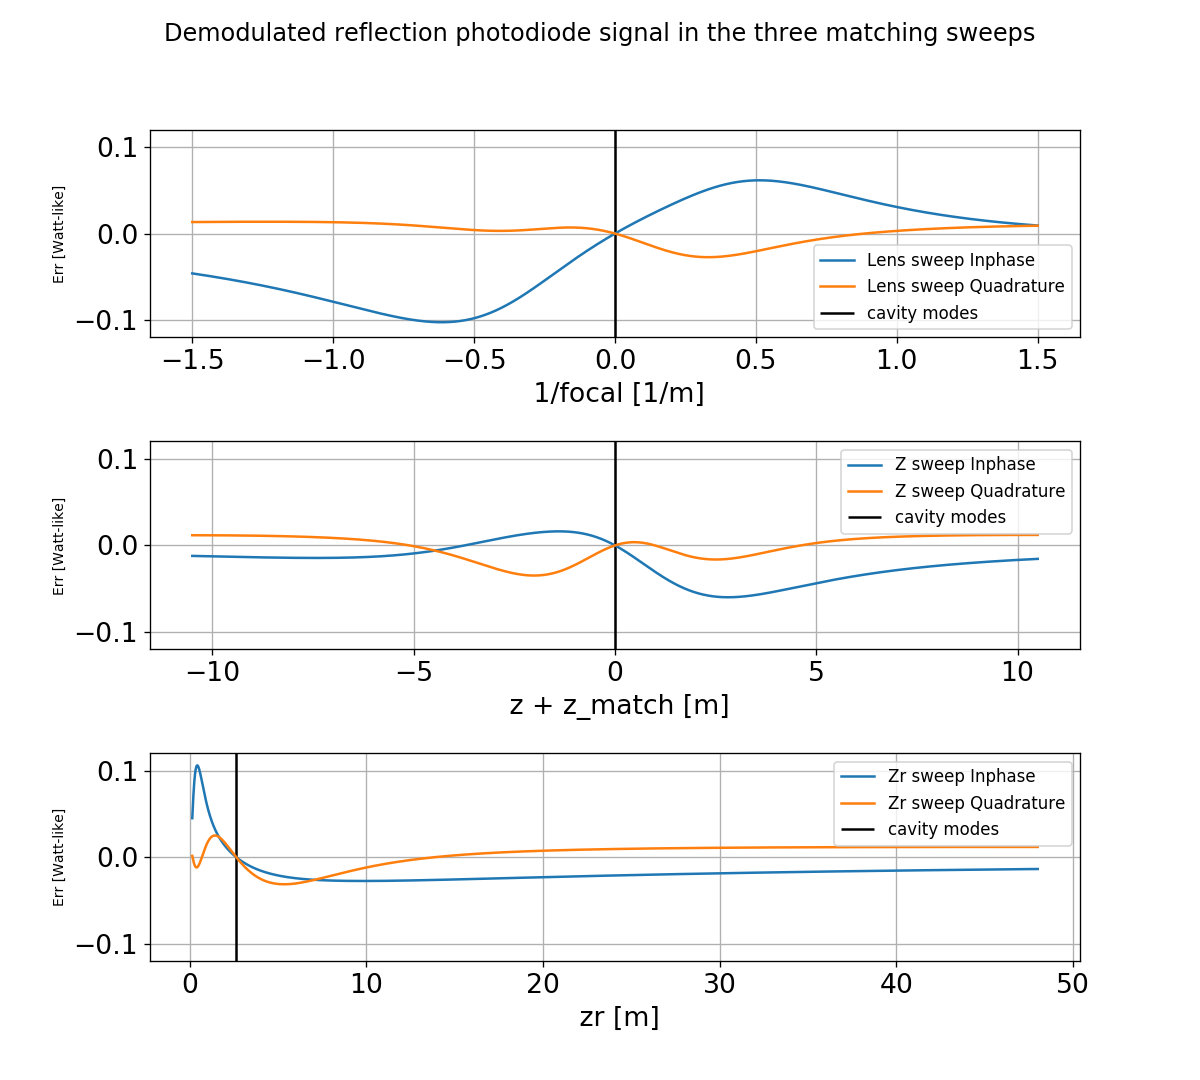

/home/mikelovskij/.local/Anaconda/envs/py34/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [32]:
#eollib.plot_powers(lens_out_dict)
fig,ax = eollib.plot_matching_sweeps(lens_out_dict, z_out_dict, zr_out_dict, lens_match=0, z_match=0, zr_match=2.64, suptitle= "Demodulated reflection photodiode signal in the three matching sweeps", save_plot=False)
ax[0].set_ylabel("Err [Watt-like]", fontsize='x-small')
ax[1].set_ylabel("Err [Watt-like]", fontsize='x-small')
ax[2].set_ylabel("Err [Watt-like]", fontsize='x-small')
#fig.savefig("Mismatch_error signal.png", dpi=360)

### Derivatives of the error signal (warning: result is wrong witn numpy<1.13 ! )

<IPython.core.display.Javascript object>


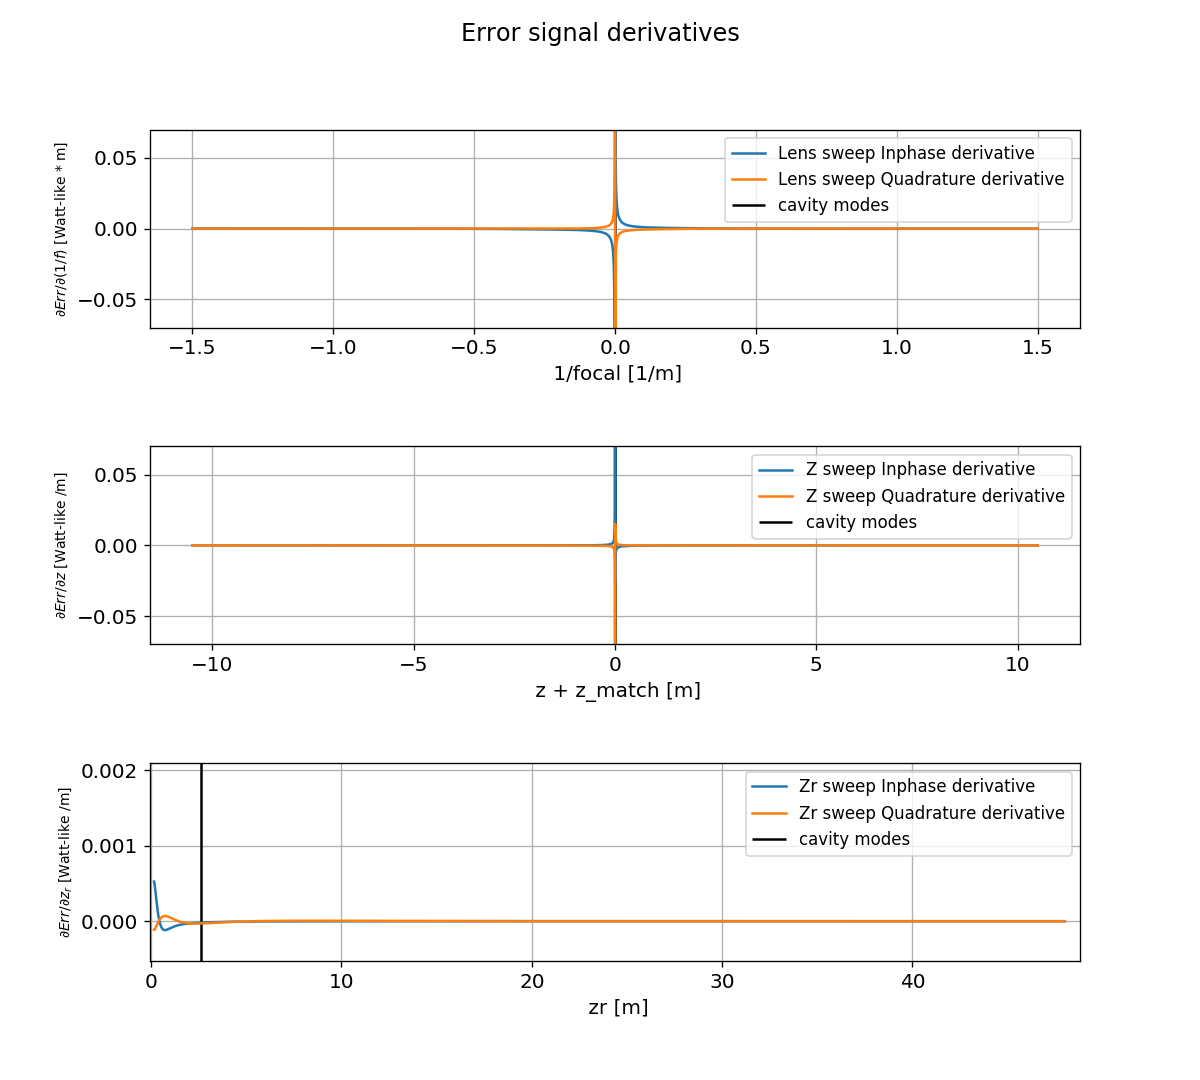

/home/mikelovskij/.local/Anaconda/envs/py34/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [33]:
fig,ax = eollib.plot_matching_sweeps_diffs(lens_out_dict, z_out_dict, zr_out_dict, lens_match=0, z_match=0, zr_match=2.64, suptitle= "Error signal derivatives", save_plot=False)
#ax[0].set_ylim([-0.15, 0.25])
#ax[1].set_ylim([-0.15, 0.25])
#ax[2].set_ylim([-0.15, 0.25])
ax[0].set_ylabel("$\partial Err/\partial (1/f)$ [Watt-like * m]", fontsize='x-small')
ax[1].set_ylabel("$\partial Err/ \partial z$ [Watt-like /m]", fontsize='x-small')
ax[2].set_ylabel("$\partial Err/\partial z_r$ [Watt-like /m]", fontsize='x-small')
#fig.savefig("Mismatch_error signal_derivatives.png", dpi=360)

<IPython.core.display.Javascript object>


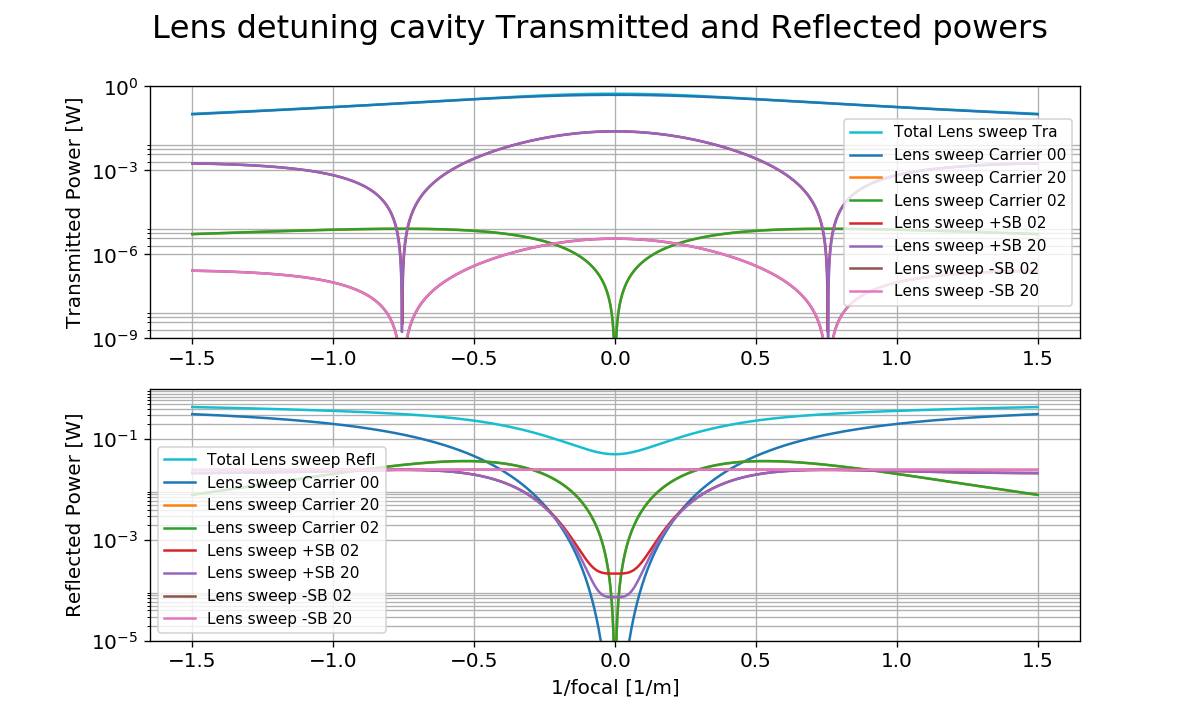

/home/mikelovskij/.local/Anaconda/envs/py34/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [34]:
fig, ax= eollib.plot_trans_refl_2(lens_out_dict, suptitle="Lens detuning cavity Transmitted and Reflected powers")
#ax[0].set_xlim([-5, 5])
#ax[1].set_xlim([-5, 5])
#ax[1].legend(loc=10, font='xx-small')
ax[0].set_ylim([10E-10, 1])
ax[0].set_ylabel("Transmitted Power [W]")
ax[1].set_ylim([10E-6, 1])
ax[1].set_ylabel("Reflected Power [W]")
ax[1].set_xlabel("1/focal [1/m]")
ax[0].legend(loc='right', fontsize='xx-small')
#fig.savefig("Lens sweep ref_tra.png", dpi=360)

<IPython.core.display.Javascript object>


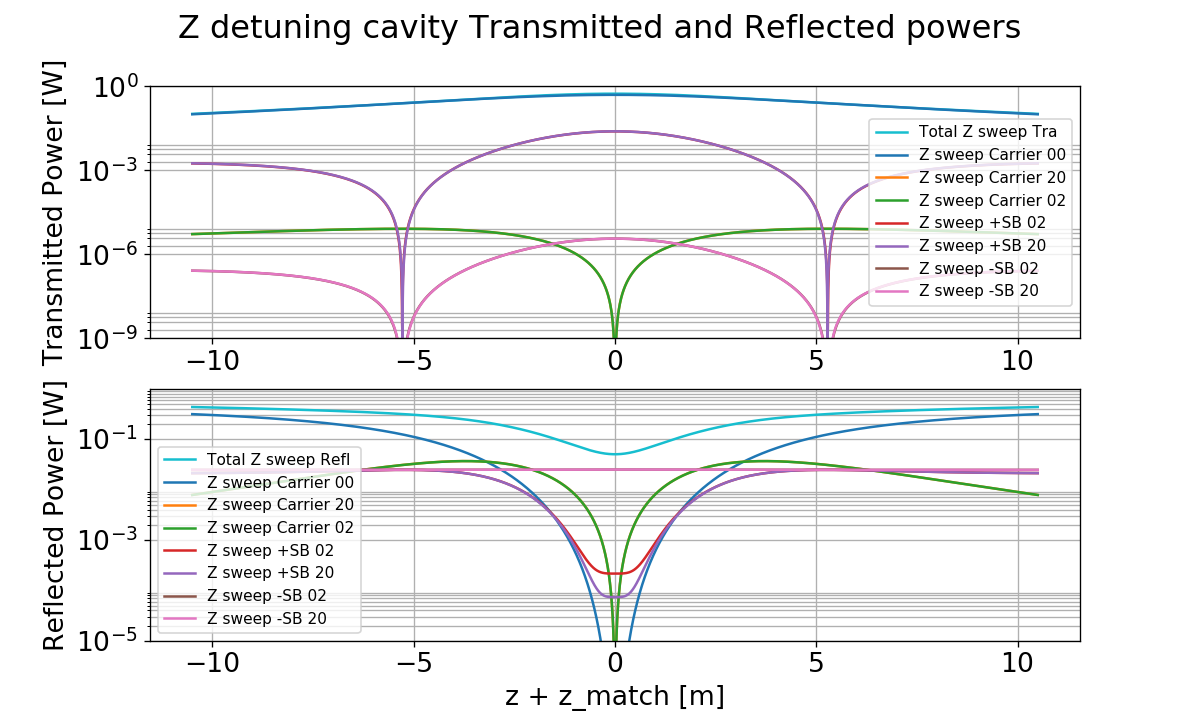

/home/mikelovskij/.local/Anaconda/envs/py34/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [35]:
fig, ax= eollib.plot_trans_refl_2(z_out_dict, suptitle="Z detuning cavity Transmitted and Reflected powers")
ax[0].legend(loc='right', fontsize='xx-small')
ax[0].set_ylim([10E-10, 1])
ax[0].set_ylabel("Transmitted Power [W]")
ax[1].set_ylim([10E-6, 1])
ax[1].set_ylabel("Reflected Power [W]")
ax[1].set_xlabel("z + z_match [m]")
#fig.savefig("Z sweep ref_tra.png", dpi=360)

<IPython.core.display.Javascript object>


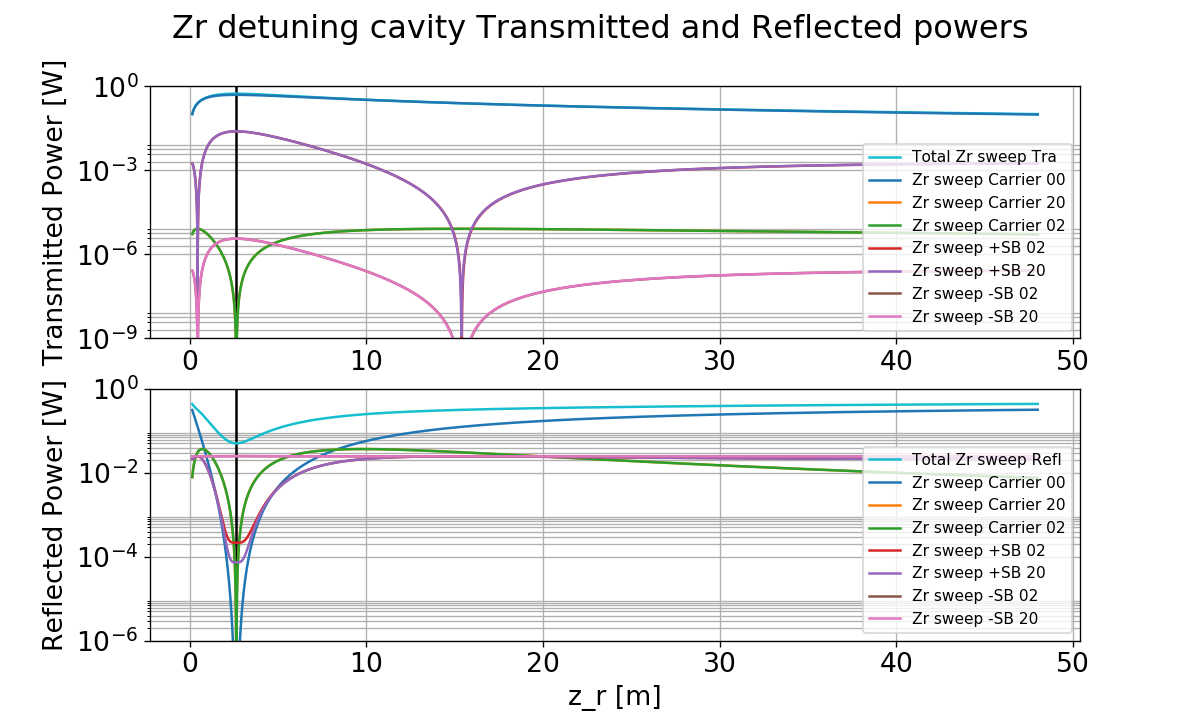

/home/mikelovskij/.local/Anaconda/envs/py34/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [36]:
fig, ax= eollib.plot_trans_refl_2(zr_out_dict, suptitle="Zr detuning cavity Transmitted and Reflected powers")
ax[0].set_ylim([10E-10, 1])
ax[0].set_ylabel("Transmitted Power [W]")
ax[0].vlines(2.64, 10E-10, 1 )
ax[1].set_ylim([10E-7, 1])
ax[1].set_ylabel("Reflected Power [W]")
ax[1].set_xlabel("z_r [m]")
ax[1].vlines(2.64, 10E-7, 1 )
#fig.savefig("Zr sweep ref_tra.png", dpi=360)

<IPython.core.display.Javascript object>


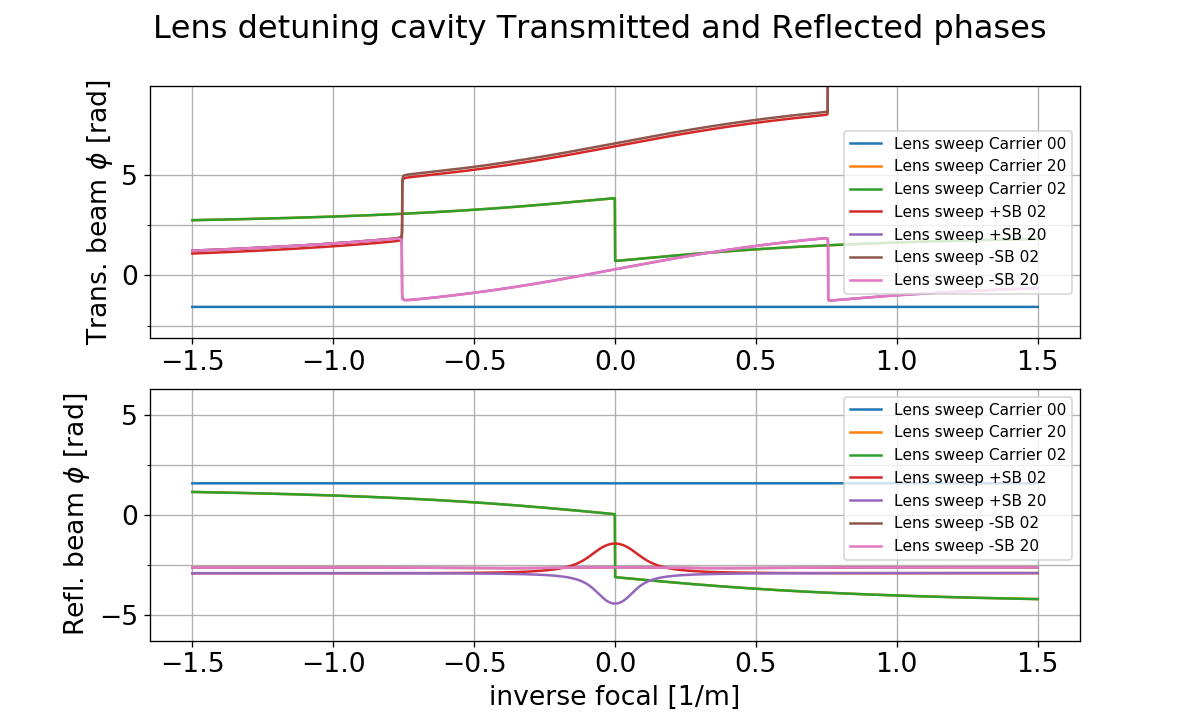

In [37]:
fig, ax= eollib.plot_trans_refl_phase_2(lens_out_dict, suptitle="Lens detuning cavity Transmitted and Reflected phases")
ax[0].set_ylim([-1*np.pi, 3*np.pi])
ax[1].set_ylim([-2*np.pi, 2*np.pi])
ax[0].legend(loc='right', fontsize='xx-small')
ax[0].set_ylabel("Trans. beam $\phi$ [rad]")
ax[1].set_ylabel("Refl. beam $\phi$ [rad]")
ax[1].set_xlabel("inverse focal [1/m]")
#fig.savefig("lens sweep ref_tra_phases.png", dpi=400)

<IPython.core.display.Javascript object>


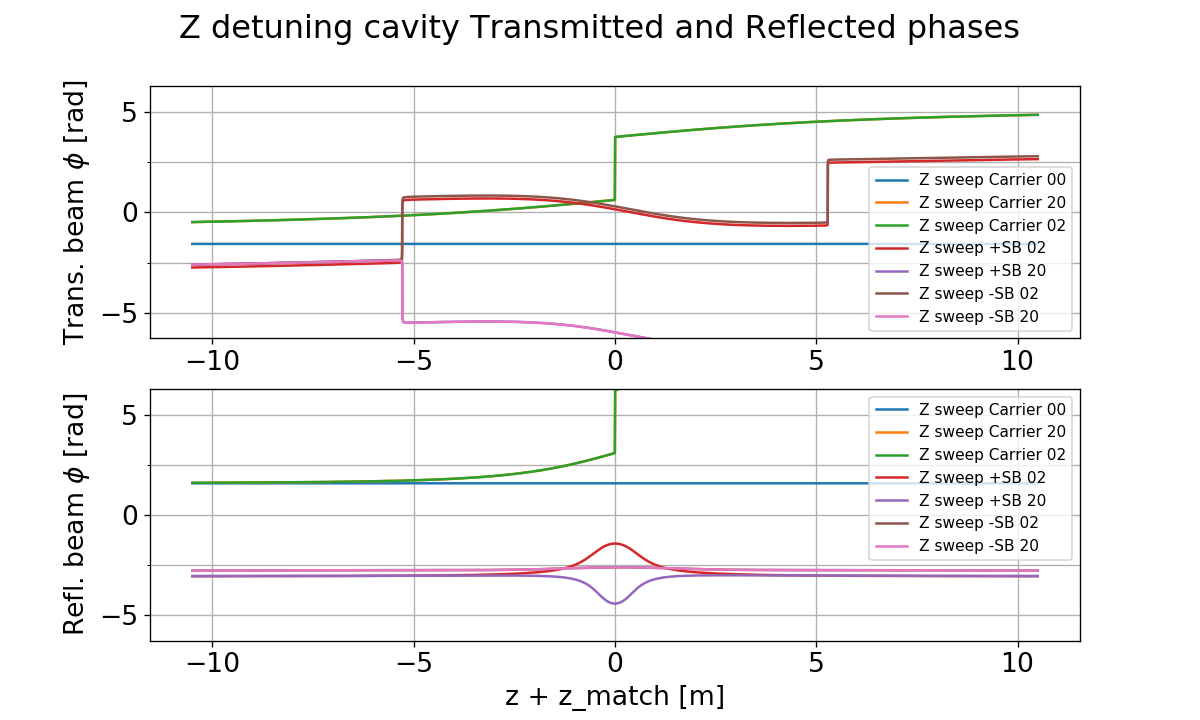

In [38]:
fig, ax= eollib.plot_trans_refl_phase_2(z_out_dict, suptitle="Z detuning cavity Transmitted and Reflected phases")
ax[0].set_ylim([-2*np.pi, 2*np.pi])
ax[1].set_ylim([-2*np.pi, 2*np.pi])
ax[0].set_ylabel("Trans. beam $\phi$ [rad]")
ax[1].set_ylabel("Refl. beam $\phi$ [rad]")
ax[1].set_xlabel("z + z_match [m]")

#fig.savefig("Z sweep ref_tra_phases.png", dpi=400)

<IPython.core.display.Javascript object>


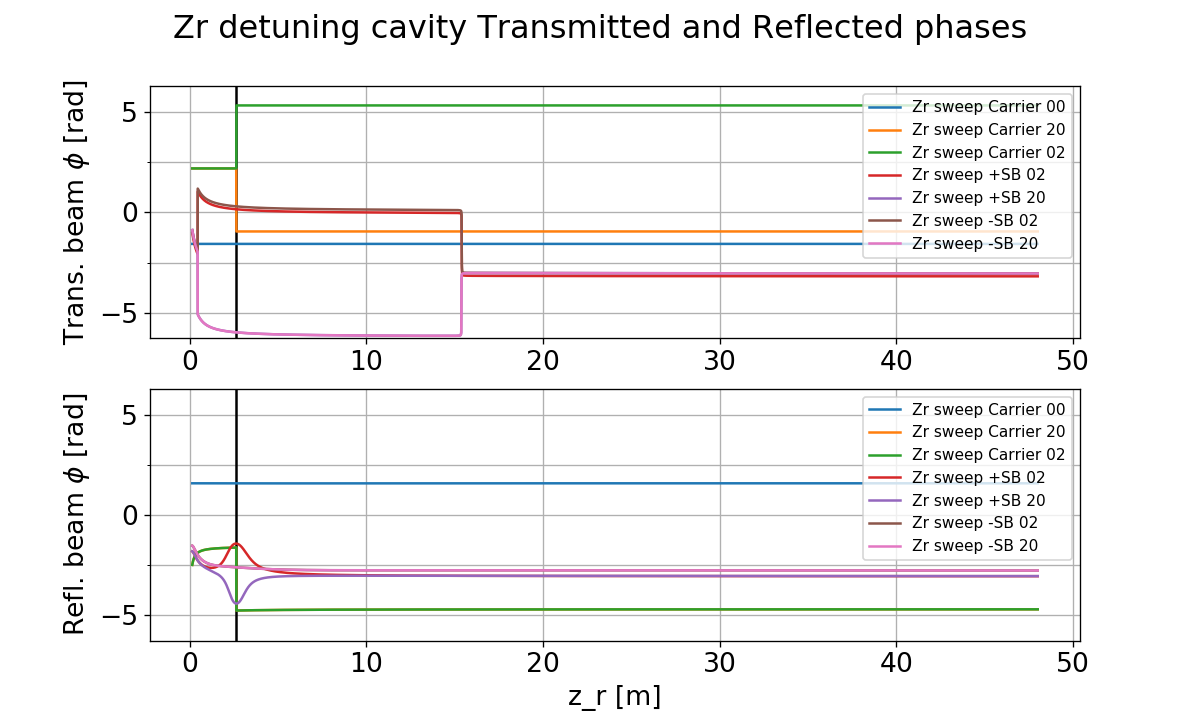

In [39]:
fig, ax= eollib.plot_trans_refl_phase_2(zr_out_dict, suptitle="Zr detuning cavity Transmitted and Reflected phases")
ax[0].set_ylim([-2*np.pi, 2*np.pi])
ax[1].set_ylim([-2*np.pi, 2*np.pi])
ax[0].set_ylabel("Trans. beam $\phi$ [rad]")
ax[1].set_ylabel("Refl. beam $\phi$ [rad]")
ax[1].set_xlabel("z_r [m]")
ax[0].vlines(2.64, -2*np.pi, 2*np.pi)
ax[1].vlines(2.64, -2*np.pi, 2*np.pi)
#fig.savefig("Zr sweep ref_tra_phases.png", dpi=400)

# 7. Let's try repeating the mismatch simulations with "wrong" frequency sidebands

In [40]:
wrong_constants = """
# Sideband and demodualtion frequencies
const f1 20M
const f2 -20M
maxtem 4
"""

### We define and parse again the kat code

In [41]:
wrong_lens_kat = finesse.kat()
#tri_kat.verbose = True
code = ""
for c in [source, out_cav_spaces_with_lens, tri_cav, detectors, gauss_params, wrong_constants, lens_sweep]:
    code += c
#print(code)
wrong_lens_kat.parse(code)
wrong_lens_kat.trace = 8
wrong_lens_kat.inphase.phase1 = phi
wrong_lens_kat.quadrature.phase1 = phi + 90

Parsing `tem i1 0 2 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 0 0 1.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 2 0 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 2 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 0 0.0 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 2 0 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 2 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 0 0.0 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 2 0 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `startnode n_source_out` into pykat object not implemented yet, added as extra line.


In [42]:
wrong_z_kat = finesse.kat()
#tri_kat.verbose = True
code = ""
for c in [source, out_cav_spaces_with_lens, tri_cav, detectors, gauss_params, wrong_constants, matching_z_sweep]:
    code += c
#print(code)
wrong_z_kat.parse(code)
wrong_z_kat.trace = 8
wrong_z_kat.inphase.phase1 = phi
wrong_z_kat.quadrature.phase1 = phi + 90

Parsing `tem i1 0 2 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 0 0 1.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 2 0 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 2 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 0 0.0 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 2 0 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 2 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 0 0.0 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 2 0 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `startnode n_source_out` into pykat object not implemented yet, added as extra line.

put command `put gauss1 zx $zl1` refers to non-existing
component


Parsing `put gauss1 zx $zl1` into pykat object

In [43]:
wrong_zr_kat = finesse.kat()
#tri_kat.verbose = True
code = ""
for c in [source, out_cav_spaces_with_lens, tri_cav, detectors, gauss_params, wrong_constants, matching_zr_sweep]:
    code += c
#print(code)
wrong_zr_kat.parse(code)
wrong_zr_kat.trace = 8
wrong_zr_kat.inphase.phase1 = phi
wrong_zr_kat.quadrature.phase1 = phi + 90

Parsing `tem i1 0 2 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 0 0 1.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i1 2 0 0.0 0` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 2 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 0 0 0.0 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i2 2 0 0.1 180` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 2 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 0 0 0.0 90` into pykat object not implemented yet, added as extra line.
Parsing `tem i3 2 0 0.1 90` into pykat object not implemented yet, added as extra line.
Parsing `startnode n_source_out` into pykat object not implemented yet, added as extra line.

put command `put gauss1 zry $x1` refers to non-existing
component


Parsing `put gauss1 zry $x1` into pykat object

### Let's run the simulations with the wrong sidebands

In [44]:
wrong_lens_out = wrong_lens_kat.run()

--------------------------------------------------------------
Running kat - Started at 2018-07-30 16:07:25.325481


100% | ETA:  0:00:00 | Saving data                                             


Finished in 9.94888 seconds


In [45]:
wrong_z_out = wrong_z_kat.run()

--------------------------------------------------------------
Running kat - Started at 2018-07-30 16:07:35.283619


100% | ETA:  0:00:00 | Saving data                                             


Finished in 14.0753 seconds


In [46]:
wrong_zr_out = wrong_zr_kat.run()

--------------------------------------------------------------
Running kat - Started at 2018-07-30 16:07:49.366785


100% | ETA:  0:00:00 | Saving data                                             


Finished in 13.6392 seconds


### Let's redefine the output dictionaries adding the wrong sidebands simulation results

In [47]:
lens_out_dict_ws = {"Lens sweep" : lens_out, "Wrong sidebands": wrong_lens_out}
z_out_dict_ws = {"Z sweep" : z_out, "Wrong sidebands": wrong_z_out}
zr_out_dict_ws = {"Zr sweep" : zr_out, "Wrong sidebands": wrong_zr_out} 

<IPython.core.display.Javascript object>


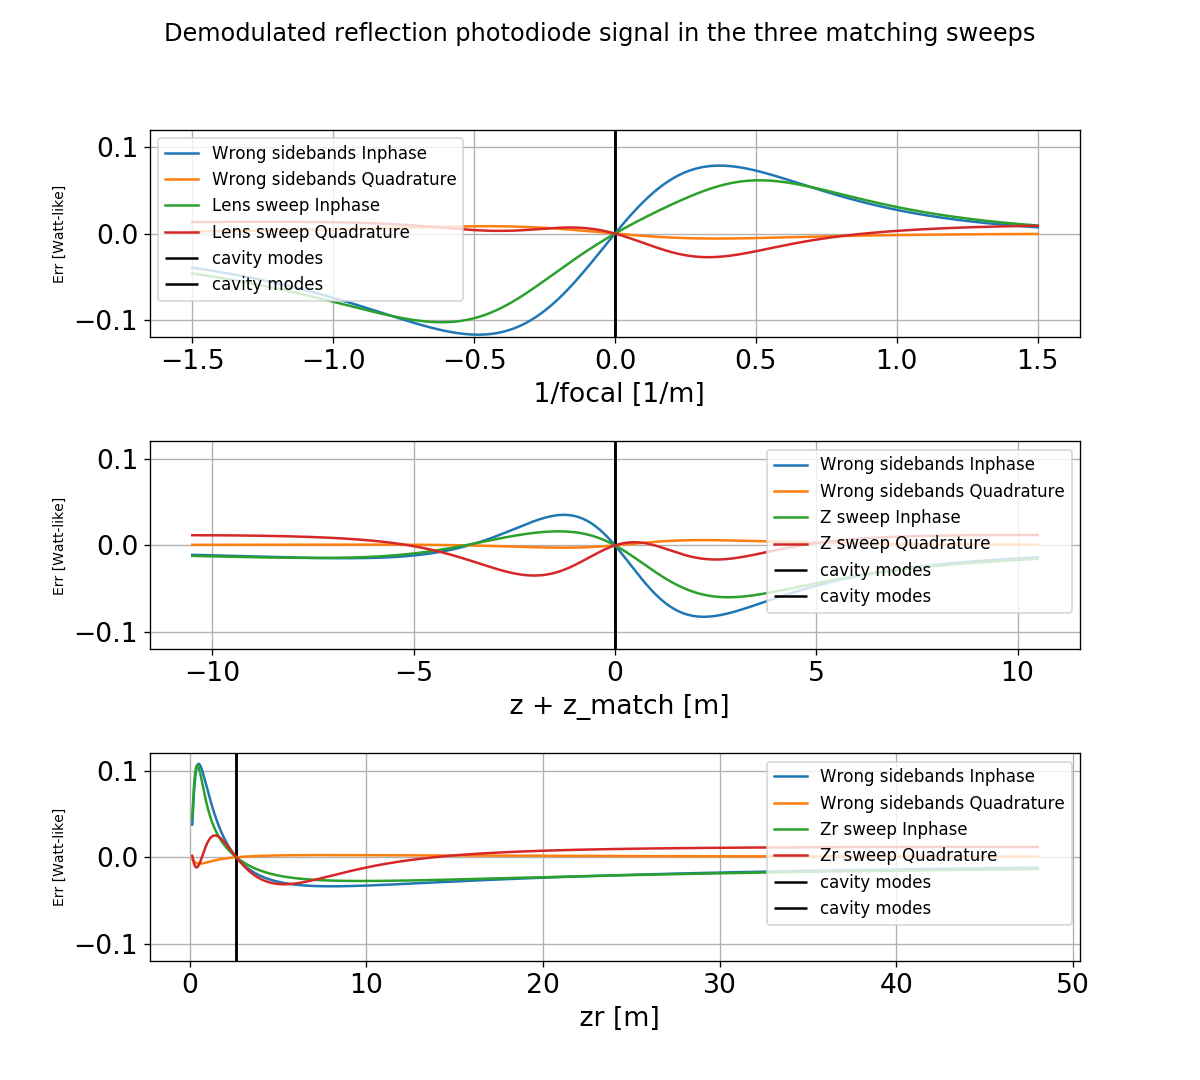

/home/mikelovskij/.local/Anaconda/envs/py34/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [48]:
fig,ax = eollib.plot_matching_sweeps(lens_out_dict_ws, z_out_dict_ws, zr_out_dict_ws, lens_match=0, z_match=0, zr_match=2.64, suptitle= "Demodulated reflection photodiode signal in the three matching sweeps", save_plot=False)


In [49]:
ax[0].set_ylabel("Err [Watt-like]", fontsize='x-small')
ax[1].set_ylabel("Err [Watt-like]", fontsize='x-small')
ax[2].set_ylabel("Err [Watt-like]", fontsize='x-small')
fig.savefig("Mismatch_error signal with wrong_sidebands.png", dpi=360)

<IPython.core.display.Javascript object>


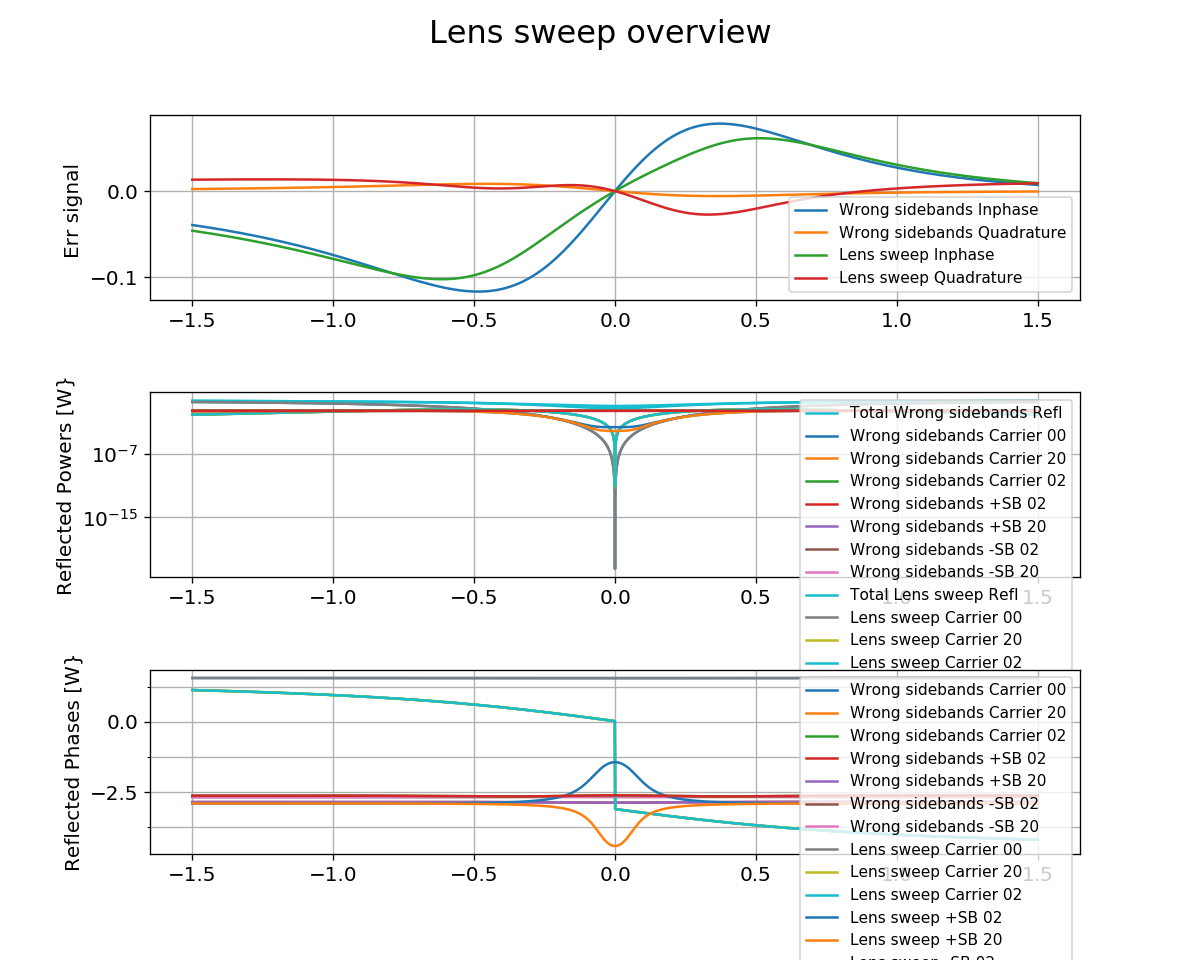

/home/mikelovskij/.local/Anaconda/envs/py34/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(<matplotlib.figure.Figure at 0x7fb7850ff940>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb783cd5940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb783b9fc18>], dtype=object))

In [50]:
eollib.plot_overview(lens_out_dict_ws)